# Foundations of neural networks

## How neural networks are build?
Biological vs. Artificial Neurons
The concept of artificial neural networks is heavily inspired by the biological neurons found in the human brain. Below is a comparison illustrating the structural similarities between a biological neuron and a mathematical (artificial) neuron model.


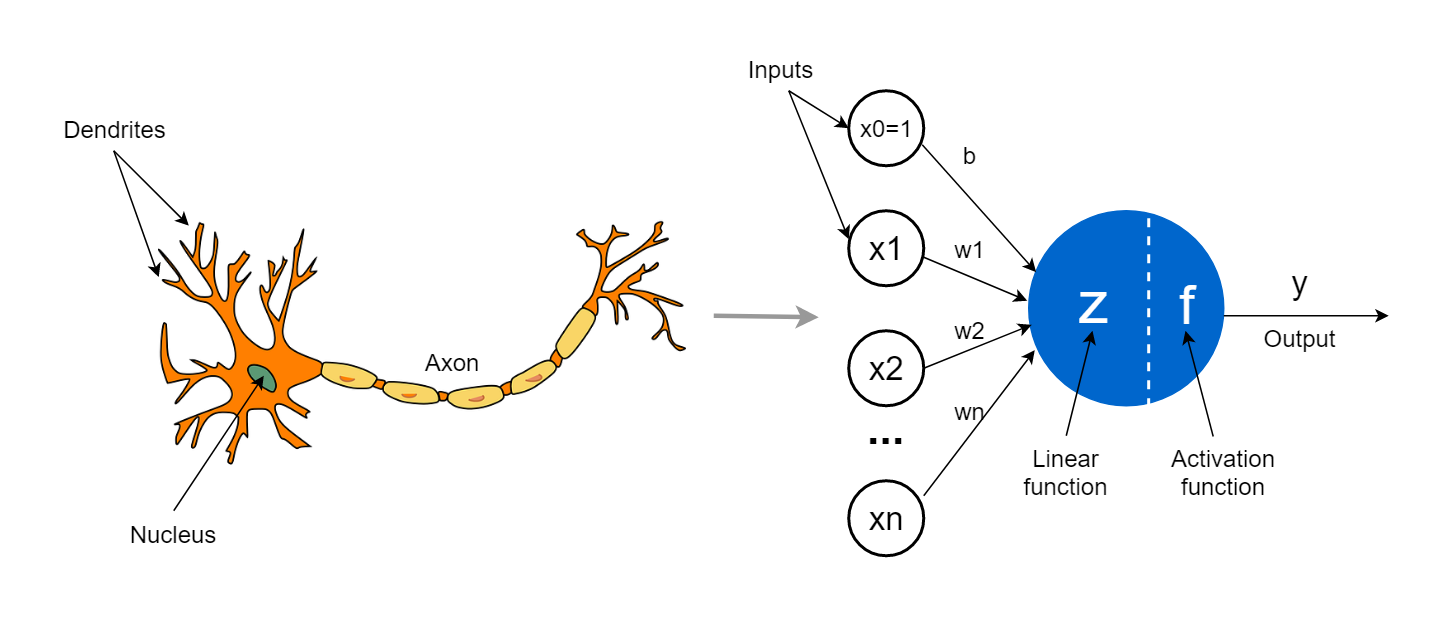

- passing signal depending on activation
- we simulate this process with matrix multiplication

### Weights and activation functions

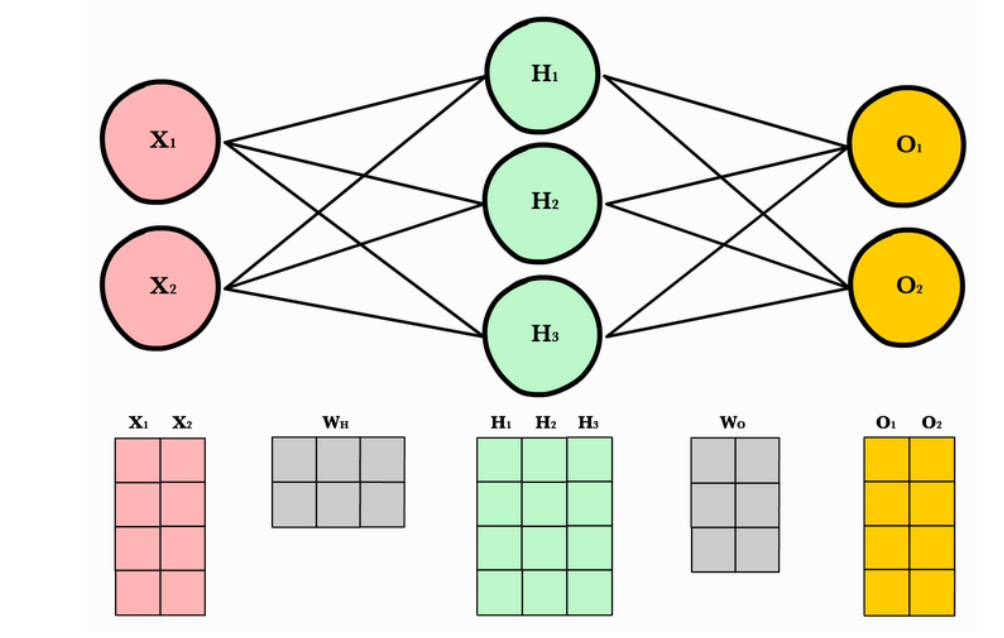

- inputs / hidden state / output
- matrices of weights

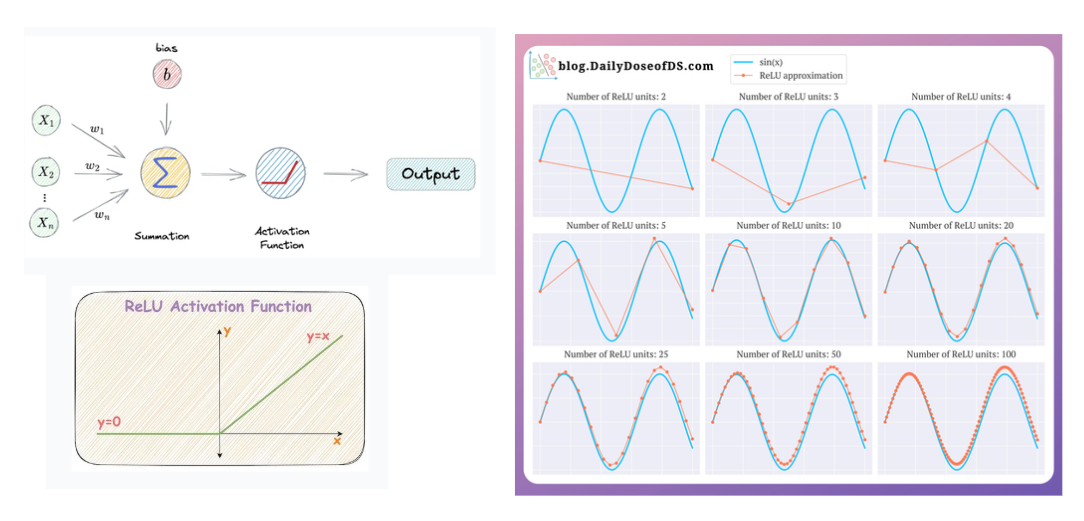

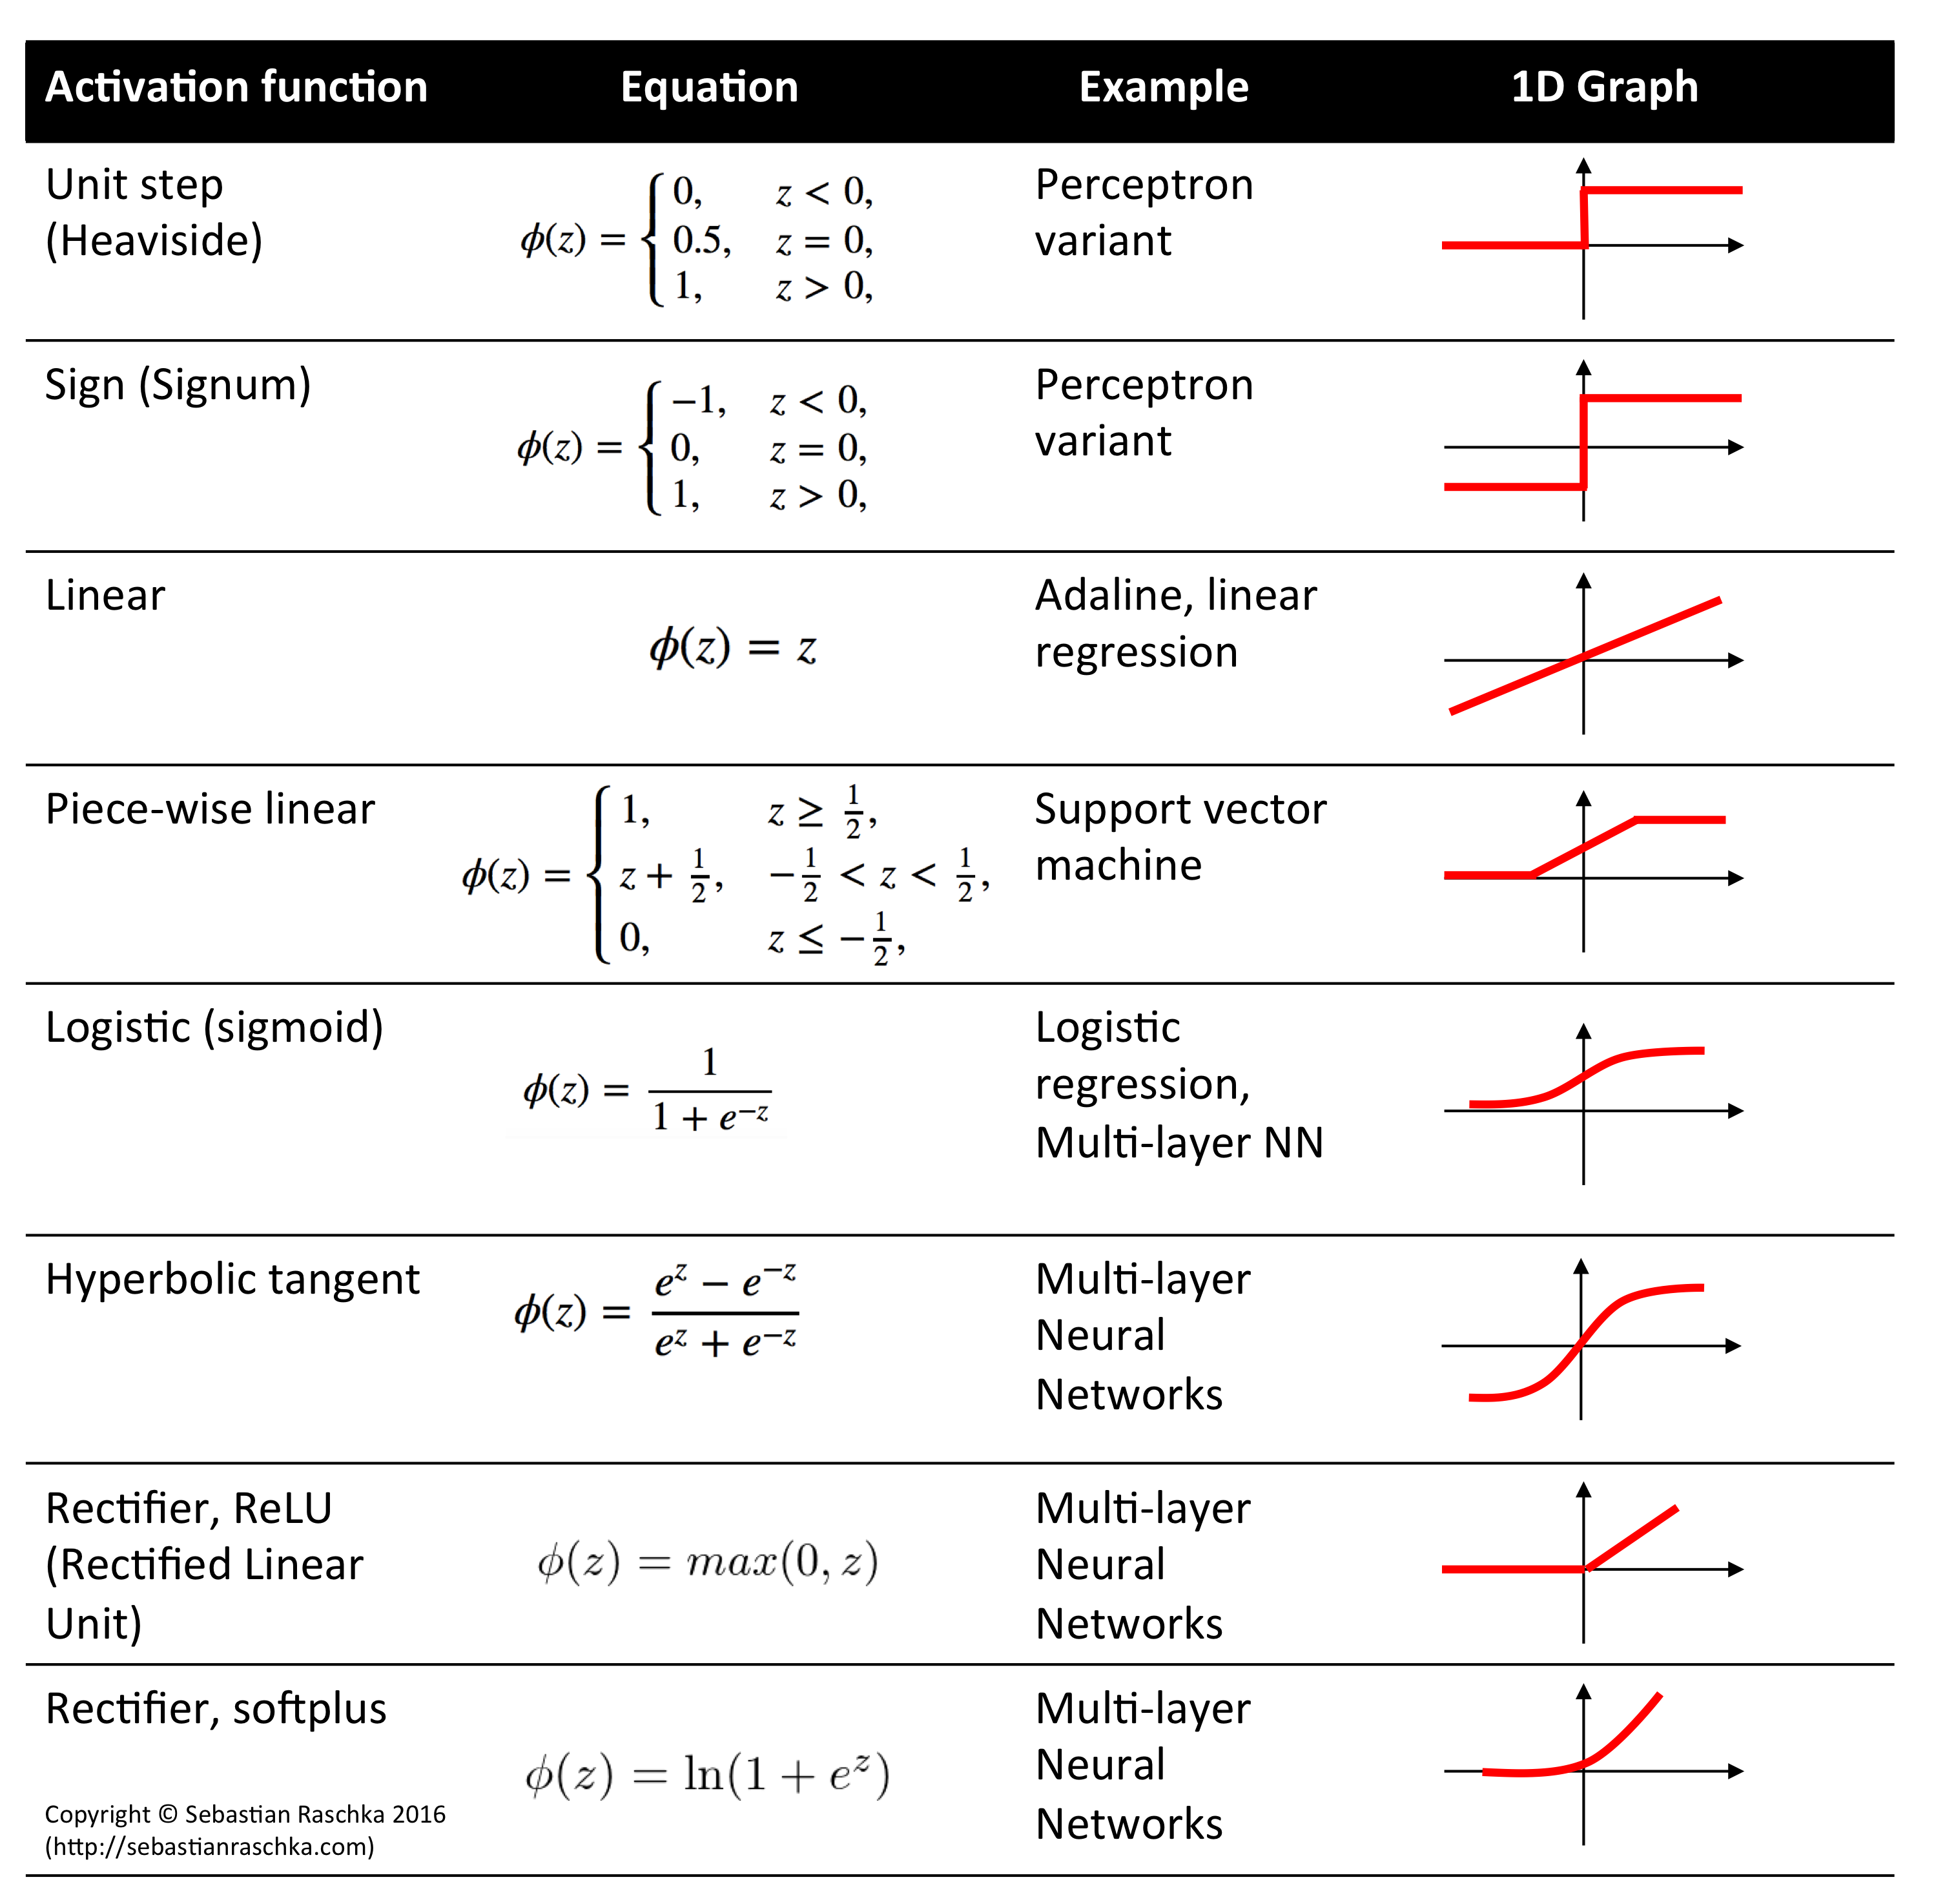

## How do we learn weights?
- loss function
- backpropagation

![image.png](attachment:95c4ca51-43cc-44a8-b36f-08d77ae030d1.png)

![image.png](attachment:df30aa4b-53a1-4ec5-b7f9-c14934dea52b.png)

# Neural networks from scratch

In [8]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [9]:
def load_data():
    print("Loading sklearn Digits data (8x8 pixel images)...")
    # Load the smaller digits dataset (approx 1797 samples)
    digits = load_digits()

    X = digits.data  # Shape is (1797, 64)
    y = digits.target

    # Normalize pixel values (0-16) to be between 0 and 1
    X = X / 16.0

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    y_encoded = encoder.fit_transform(y.reshape(-1, 1))

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

ReLU (Rectified Linear Unit):$$f(x) = \max(0, x)$$This introduces non-linearity. Without this, the neural network would behave exactly like a single linear regression model, regardless of how many layers you add.Derivative: The slope is 1 if $x > 0$, and 0 otherwise.Softmax (Output):$$\sigma(z)_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$This converts raw scores (logits) into probabilities that sum to 1.Cross-Entropy Loss:$$L = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{C} y_{i,k} \log(\hat{y}_{i,k})$$This penalizes the model heavily when it predicts a low probability for the correct class ($y_{i,k}=1$).

In [7]:
def relu(Z):
    """
    Rectified Linear Unit: returns Z if Z > 0, else 0
    """
    return np.maximum(0, Z)

def relu_derivative(Z):
    """
    Derivative of ReLU: 1 if Z > 0, else 0
    """
    return Z > 0

def softmax(Z):
    """
    Softmax activation for output layer.
    Subtracts max(Z) for numerical stability to prevent overflow.
    """
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    """
    Categorical Cross Entropy Loss.
    """
    m = y_true.shape[0]
    # Add small epsilon to prevent log(0)
    loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m
    return loss

Layer DefinitionsWe model the network using matrices.
- Input ($X$): Shape $(m, 784)$, where $m$ is the number of images.
- Hidden Layer ($W_1, b_1$):
    -   $W_1$ is $(784, 64)$. It transforms 784 input pixels into 64 hidden features.
    -   $b_1$ is $(1, 64)$. This is the bias vector.
- Output Layer
    -   ($W_2, b_2$):$W_2$ is $(64, 10)$. It transforms 64 hidden features into 10 class scores.
    - $b_2$ is $(1, 10)$.2.

In [3]:
class TwoLayerNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.lr = learning_rate

        # --- Layers Definition ---
        # Weights initialized with small random values to break symmetry
        # Biases initialized to zeros

        # Layer 1 (Hidden): shapes (784, 64) and (1, 64)
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        # Layer 2 (Output): shapes (64, 10) and (1, 10)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        """
        Forward propagation through the network
        """
        # Linear transform for hidden layer
        self.Z1 = np.dot(X, self.W1) + self.b1
        # Non-linear activation (ReLU)
        self.A1 = relu(self.Z1)

        # Linear transform for output layer
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        # Activation (Softmax)
        self.A2 = softmax(self.Z2)

        return self.A2

    def backward(self, X, y_true):
        """
        Backpropagation to calculate gradients
        """
        m = X.shape[0] # Batch size

        # --- Derivative of Loss w.r.t Output (Z2) ---
        # When combining Softmax and Cross-Entropy, the derivative simplifies nicely:
        # dZ2 = Predicted - Actual
        dZ2 = self.A2 - y_true

        # --- Gradients for Layer 2 (Output) ---
        # dW2 = (A1 transposed) dot (dZ2) / m
        self.dW2 = np.dot(self.A1.T, dZ2) / m
        self.db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        # --- Propagate error to Hidden Layer ---
        # Error at hidden layer (dA1) = (dZ2) dot (W2 transposed)
        dA1 = np.dot(dZ2, self.W2.T)

        # --- Derivative through ReLU ---
        # dZ1 = dA1 * relu_derivative(Z1)
        dZ1 = dA1 * relu_derivative(self.Z1)

        # --- Gradients for Layer 1 (Hidden) ---
        self.dW1 = np.dot(X.T, dZ1) / m
        self.db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    def update_params(self):
        """
        Gradient Descent Step
        """
        self.W1 -= self.lr * self.dW1
        self.b1 -= self.lr * self.db1
        self.W2 -= self.lr * self.dW2
        self.b2 -= self.lr * self.db2

    def train(self, X_train, y_train, epochs=100):
        # --- Training Loop ---
        for i in range(epochs):
            # 1. Forward Pass
            y_pred = self.forward(X_train)

            # 2. Compute Loss (for monitoring)
            loss = cross_entropy_loss(y_train, y_pred)

            # 3. Backward Pass (Calculate Gradients)
            self.backward(X_train, y_train)

            # 4. Update Weights
            self.update_params()

            if i % 10 == 0:
                print(f"Epoch {i}: Loss {loss:.4f}")

    def predict(self, X):
        # Return index of highest probability
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

We calculate gradients using the Chain Rule, moving from the output backward.Output Error ($dZ_2$):The derivative of the Loss function combined with Softmax is incredibly elegant:$$dZ_2 = A_2 - Y$$(Where $A_2$ is our prediction and $Y$ is the actual one-hot label).Hidden Layer Error ($dZ_1$):We take the error from the output ($dZ_2$), multiply it by the weights connecting the layers ($W_2$), and then multiply element-wise by the derivative of the activation function (ReLU derivative).$$dZ_1 = (dZ_2 \cdot W_2^T) \times \text{ReLU}'(Z_1)$$Weight Gradients ($dW$):The gradient for the weights is the dot product of the input to that layer and the error of that layer.$$dW_1 = \frac{1}{m} X^T \cdot dZ_1$$

Training loop
- Forward: Pass data through to get predictions.
- Loss: Calculate how wrong we are.
- Backward: Calculate how to change weights to reduce error.
- Update: $W = W - \text{learning\_rate} \times dW$.

In [11]:
# 1. Load Data
X_train, X_test, y_train, y_test = load_data()

# 2. Define Architecture
input_size = 64
hidden_size = 32    # Reduced hidden size for smaller dataset
output_size = 10    # Digits 0-9

# Initialize model
model = TwoLayerNN(input_size, hidden_size, output_size, learning_rate=0.1)

# 3. Train (Small dataset converges quickly, so fewer epochs needed)
print("\nStarting Training...")
model.train(X_train, y_train, epochs=1000)

# 4. Evaluate
predictions = model.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test_labels)

print(f"\nFinal Accuracy on Test Set: {accuracy * 100:.2f}%")

Loading sklearn Digits data (8x8 pixel images)...

Starting Training...
Epoch 0: Loss 2.3027
Epoch 10: Loss 2.3021
Epoch 20: Loss 2.3015
Epoch 30: Loss 2.3008
Epoch 40: Loss 2.2998
Epoch 50: Loss 2.2986
Epoch 60: Loss 2.2968
Epoch 70: Loss 2.2943
Epoch 80: Loss 2.2908
Epoch 90: Loss 2.2858
Epoch 100: Loss 2.2785
Epoch 110: Loss 2.2680
Epoch 120: Loss 2.2529
Epoch 130: Loss 2.2314
Epoch 140: Loss 2.2009
Epoch 150: Loss 2.1587
Epoch 160: Loss 2.1018
Epoch 170: Loss 2.0276
Epoch 180: Loss 1.9357
Epoch 190: Loss 1.8281
Epoch 200: Loss 1.7097
Epoch 210: Loss 1.5872
Epoch 220: Loss 1.4669
Epoch 230: Loss 1.3535
Epoch 240: Loss 1.2494
Epoch 250: Loss 1.1558
Epoch 260: Loss 1.0723
Epoch 270: Loss 0.9979
Epoch 280: Loss 0.9315
Epoch 290: Loss 0.8720
Epoch 300: Loss 0.8184
Epoch 310: Loss 0.7699
Epoch 320: Loss 0.7260
Epoch 330: Loss 0.6861
Epoch 340: Loss 0.6498
Epoch 350: Loss 0.6167
Epoch 360: Loss 0.5866
Epoch 370: Loss 0.5591
Epoch 380: Loss 0.5339
Epoch 390: Loss 0.5108
Epoch 400: Loss 0.4

# Neural network in PyTorch

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

In [13]:
# --- 1. Data Loading (Modified for PyTorch) ---
def load_data_pytorch():
    digits = load_digits()
    X = digits.data
    y = digits.target # Keep as integers (0-9) for PyTorch CrossEntropy

    # Normalize (0-16 -> 0-1)
    X = X / 16.0

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert numpy arrays to PyTorch Tensors
    # Inputs must be Float (float32), Targets must be Long (int64)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test  = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test  = torch.tensor(y_test, dtype=torch.long)

    return X_train, X_test, y_train, y_test

In [15]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()

        # Layer 1: Input -> Hidden (Equivalent to W1, b1)
        self.layer1 = nn.Linear(input_size, hidden_size)

        # Layer 2: Hidden -> Output (Equivalent to W2, b2)
        self.layer2 = nn.Linear(hidden_size, output_size)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Forward pass: Input -> Linear -> ReLU -> Linear -> Output (Logits)
        """
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        # Note: No Softmax here! CrossEntropyLoss handles it.
        return out

In [17]:
input_size = 64
hidden_size = 32
output_size = 10
learning_rate = 0.1
epochs = 1000

# Load Data
X_train, X_test, y_train, y_test = load_data_pytorch()

# Initialize Model
model = TwoLayerNN(input_size, hidden_size, output_size)

# Loss and Optimizer
# nn.CrossEntropyLoss applies Softmax internally + Negative Log Likelihood
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print("\nStarting PyTorch Training...")

# --- Training Loop ---
for epoch in range(epochs):
    # 1. Forward Pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # 2. Backward Pass and Optimization
    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Calculate new gradients (Auto-differentiation)
    optimizer.step()       # Update weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

# --- Evaluation ---
# Temporarily turn off gradient calculation for testing (saves memory)
with torch.no_grad():
    test_outputs = model(X_test)
    # Get the index of the max logit (the predicted class)
    _, predictions = torch.max(test_outputs, 1)

    # Calculate accuracy
    correct = (predictions == y_test).sum().item()
    accuracy = correct / y_test.size(0)

print(f"\nFinal Accuracy on Test Set: {accuracy * 100:.2f}%")


Starting PyTorch Training...
Epoch 0: Loss 2.2937
Epoch 100: Loss 1.2333
Epoch 200: Loss 0.5021
Epoch 300: Loss 0.3101
Epoch 400: Loss 0.2342
Epoch 500: Loss 0.1922
Epoch 600: Loss 0.1648
Epoch 700: Loss 0.1451
Epoch 800: Loss 0.1302
Epoch 900: Loss 0.1185

Final Accuracy on Test Set: 96.11%


## How to scale up for more complex problems?
- more layer (depth of model)
- wider layer (width of model)
- more training (epochs, learning rate)